# PA5: Building a car classifier

In [1]:
import tensorflow as tf
import numpy as np

## Loading data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255)

In [12]:
# directory
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [13]:
Xbatch, Ybatch = train_generator.next()

In [14]:
Xbatch.shape

(32, 64, 64, 3)

In [15]:
Ybatch[4]

1.0

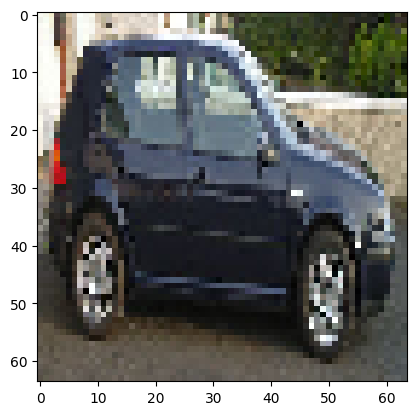

In [16]:
from matplotlib import pyplot as plt

plt.imshow(Xbatch[4]);

In [19]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=False)

Found 576 images belonging to 2 classes.


## Part 1: Training a convolutional neural network

We are using an input size of 64x64 pixels. We experimented with 128x128 pixels, but it did not yield a benefit.

Our CNN consists of 4 convolutional layers with 2 max pooling layers inbetween.
Finally, 2 dense layers followed by a final dense layer with sigmoid activiation function to get the probability of the class an image belongs to (i.e. car / not car).

As optimizer, we are using Adam with binary crossentropy loss function.

In [25]:
from tensorflow.keras import datasets, layers, models

def make_convnet():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3), padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    # optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [89]:
cnn_model = make_convnet()
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                 

We are training for a maximum of 40 epochs but use early stopping in case our validation loss is not improving after 5 epochs.

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

nb_epochs = 40

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [91]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=early_stopping
)

Epoch 1/40
50/50 [==============================] - 7s 94ms/step - loss: 0.6989 - accuracy: 0.4819 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 5s 94ms/step - loss: 0.6928 - accuracy: 0.5006 - val_loss: 0.6870 - val_accuracy: 0.5174
Epoch 3/40
50/50 [==============================] - 5s 90ms/step - loss: 0.6651 - accuracy: 0.6075 - val_loss: 0.6296 - val_accuracy: 0.6476
Epoch 4/40
50/50 [==============================] - 6s 123ms/step - loss: 0.5957 - accuracy: 0.6825 - val_loss: 0.5994 - val_accuracy: 0.7274
Epoch 5/40
50/50 [==============================] - 5s 91ms/step - loss: 0.5479 - accuracy: 0.7444 - val_loss: 0.6070 - val_accuracy: 0.6944
Epoch 6/40
50/50 [==============================] - 4s 90ms/step - loss: 0.5127 - accuracy: 0.7706 - val_loss: 0.5194 - val_accuracy: 0.7448
Epoch 7/40
50/50 [==============================] - 6s 123ms/step - loss: 0.4621 - accuracy: 0.8044 - val_loss: 0.4813 - val_accuracy: 0.7639
Epoch 8/40


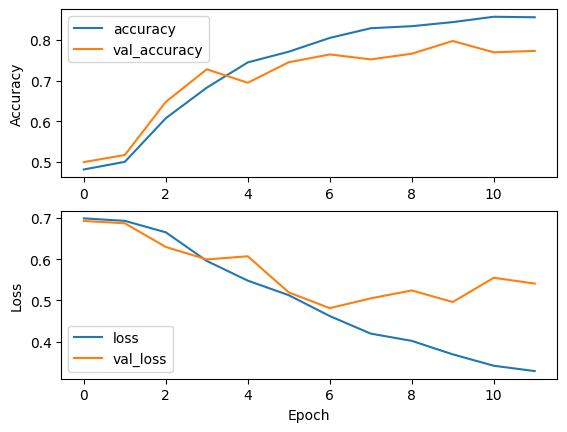

In [92]:
f, axs = plt.subplots(2)
for i, name in enumerate(['accuracy', 'loss']):
    axs[i].plot(history.history[name], label=name)
    axs[i].plot(history.history['val_' + name], label = 'val_' + name)
    axs[i].set_xlabel('Epoch') if i == 1 else None
    axs[i].set_ylabel(name.capitalize())
    axs[i].legend(loc='lower left' if i == 1 else 'upper left')

As we can see, the early stopping kicks in after about 12 epochs of training. While the training loss is going down quite steadily, the validation loss jumps around. We attribute this to the small size of the validation data set.
With this architecture, we reach a validation accuracy of 79.69%.

In [50]:
cnn_model.save_weights("cnn_model_PA5")

## Part 2: Data augmentation

Here we introduce variations into our training dataset.
Images are rotated, resized, flipped and sheared.

Empirically we determined that making the variations to large (e.g. `width_shift_range=0.6`) does not give accuracy benefits and only makes training more noisy.
After inspecting the training dataset, we noticed that a lot of images are really small in size, sometimes even less than our input size of 64x64.
Because of the missing detail, we think it is necessary to keep the variations small.

In [45]:
data_augmentation_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #brightness_range=[0.9,1.1],
    fill_mode='nearest',
    horizontal_flip=True,
    shear_range=0.2

)

In [46]:
train_generator_augmentation = data_augmentation_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [47]:
cnn_model_aug = make_convnet()


In [48]:
history = cnn_model_aug.fit(
    train_generator_augmentation,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=early_stopping
)

Epoch 1/40
50/50 [==============================] - 10s 153ms/step - loss: 0.6961 - accuracy: 0.5156 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/40
50/50 [==============================] - 6s 120ms/step - loss: 0.6902 - accuracy: 0.5219 - val_loss: 0.6691 - val_accuracy: 0.6233
Epoch 3/40
50/50 [==============================] - 6s 120ms/step - loss: 0.6958 - accuracy: 0.5038 - val_loss: 0.6922 - val_accuracy: 0.6042
Epoch 4/40
50/50 [==============================] - 8s 167ms/step - loss: 0.6902 - accuracy: 0.5556 - val_loss: 0.6807 - val_accuracy: 0.5295
Epoch 5/40
50/50 [==============================] - 6s 123ms/step - loss: 0.6761 - accuracy: 0.5913 - val_loss: 0.6602 - val_accuracy: 0.5920
Epoch 6/40
50/50 [==============================] - 8s 150ms/step - loss: 0.6557 - accuracy: 0.6288 - val_loss: 0.6205 - val_accuracy: 0.6771
Epoch 7/40
50/50 [==============================] - 6s 122ms/step - loss: 0.6603 - accuracy: 0.6344 - val_loss: 0.6550 - val_accuracy: 0.6042
Epoch

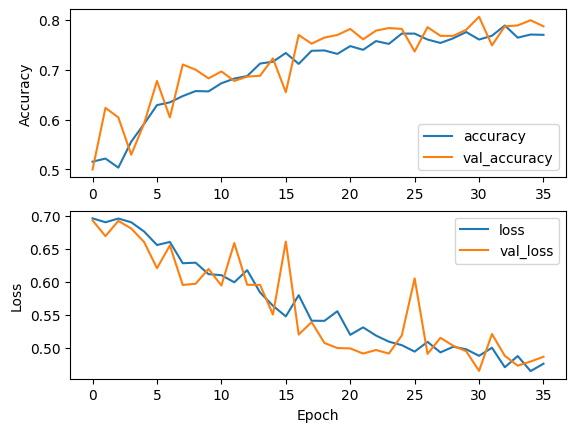

In [49]:
f, axs = plt.subplots(2)
for i, name in enumerate(['accuracy', 'loss']):
    axs[i].plot(history.history[name], label=name)
    axs[i].plot(history.history['val_' + name], label = 'val_' + name)
    axs[i].set_xlabel('Epoch') if i == 1 else None
    axs[i].set_ylabel(name.capitalize())
    axs[i].legend(loc='lower right' if i == 0 else 'upper right')

With the data augmentation in place, we can observe the following things:

- The training takes much longer, and the early stopping only kicks in after 36 epochs of training
- The loss function goes down less steadily

We presume the latter is stemming from the fact that the model has a hard time trying to fit the many variations introduced by the data augmentation. However, from the accuracy reading we find that it provides a small benefit compared to the unaugmented version, i.e. the model generalizes better.

In [ ]:
cnn_model_aug.save_weights("cnn_model_aug_PA5")

## Applying a pre-trained convolutional neural network

In [51]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 15s 0us/step


In [52]:
image = load_img("a5_images/validation/car/0000.jpg", target_size=(224,224))

image = img_to_array(image)

image = preprocess_input(image)

image = image.reshape(1, 224, 224, 3)

In [53]:
prediction = vggmodel.predict(image)

prediction = decode_predictions(prediction)
print(prediction)

35363/35363 [==============================] - 0s 0us/step
[[('n03594945', 'jeep', 0.9214068), ('n04252225', 'snowplow', 0.024327053), ('n03445924', 'golfcart', 0.014407241), ('n03930630', 'pickup', 0.012664922), ('n03478589', 'half_track', 0.005270817)]]


As we can see, VGG16 is able to predict that the image pictures a jeep with a very high confidence (92%). The next best prediction is snowplow with a confidence of only 2.4%.
It is impressive that it can even predict the subtype of car.

## Part 3: Using VGG-16 as a feature extractor

In [54]:
feature_extractor = applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [55]:
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [56]:
train_generator_vgg = vgg_data_gen.flow_from_directory(
    imgdir + '/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=False
)

validation_generator_vgg = vgg_data_gen.flow_from_directory(
    imgdir + '/validation',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'car'],
    seed=12345,
    shuffle=False
)

def create_vgg16_features():
    cnn_features_train = feature_extractor.predict(train_generator_vgg)
    cnn_features_validation = feature_extractor.predict(validation_generator_vgg)

    with open("cnn_features_train", 'wb') as f:
        np.save(f, cnn_features_train)
    with open("cnn_features_validation", 'wb') as f:
        np.save(f, cnn_features_validation)



Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [57]:
def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

To use VGG16 as a feature extractor, we use the same dense layer architecture as before but decreased dropout rate:

In [58]:
def train_on_cnnfeatures():
    with open("cnn_features_train", 'rb') as f:
        train_data = np.load(f)
    with open("cnn_features_validation", 'rb') as f:
        validation_data = np.load(f)


    model = models.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x=train_data,
        y=get_labels(1600),
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = (validation_data, get_labels(576)),
        validation_steps = validation_generator.samples // batch_size,
        epochs = 100,
        callbacks=early_stopping
    )

    return model, history

In [59]:
create_vgg16_features()

18/18 [==============================] - 1s 53ms/step


In [62]:
cnnfeatures_model, history = train_on_cnnfeatures()

Epoch 1/100
50/50 [==============================] - 2s 7ms/step - loss: 2.3699 - accuracy: 0.7819 - val_loss: 0.5932 - val_accuracy: 0.8889
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.8831 - val_loss: 0.4233 - val_accuracy: 0.9080
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: 0.3952 - accuracy: 0.9112 - val_loss: 0.4571 - val_accuracy: 0.8906
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.3022 - accuracy: 0.9212 - val_loss: 0.4672 - val_accuracy: 0.8924
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: 0.2641 - accuracy: 0.9425 - val_loss: 0.4022 - val_accuracy: 0.8906
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1686 - accuracy: 0.9563 - val_loss: 0.4328 - val_accuracy: 0.8872
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: 0.1367 - accuracy: 0.9619 - val_loss: 0.4903 - val_accuracy: 0.8958
Epoch 8/100
5

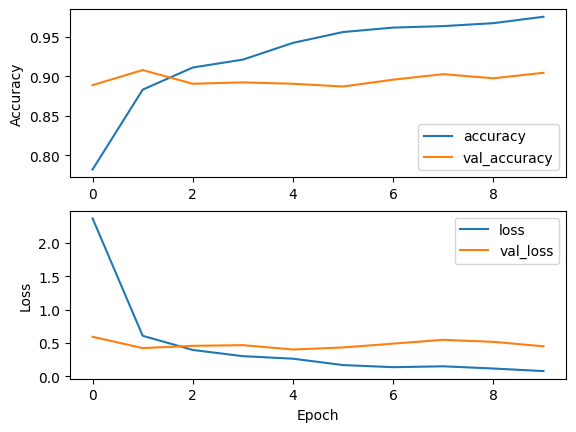

In [63]:
f, axs = plt.subplots(2)
for i, name in enumerate(['accuracy', 'loss']):
    axs[i].plot(history.history[name], label=name)
    axs[i].plot(history.history['val_' + name], label = 'val_' + name)
    axs[i].set_xlabel('Epoch') if i == 1 else None
    axs[i].set_ylabel(name.capitalize())
    axs[i].legend(loc='lower right' if i == 0 else 'upper right')

Because we do not have to train the convolutional layers, training is much faster.
After 10 epochs the early stopping kicks in, but the best validation accuracy of 90.8% is reached after training for only 2 epochs!

In [64]:
cnnfeatures_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (32, 2048)                0         
                                                                 
 dense_15 (Dense)            (32, 128)                 262272    
                                                                 
 dropout_10 (Dropout)        (32, 128)                 0         
                                                                 
 dense_16 (Dense)            (32, 64)                  8256      
                                                                 
 dropout_11 (Dropout)        (32, 64)                  0         
                                                                 
 dense_17 (Dense)            (32, 1)                   65        
                                                                 
Total params: 270,593
Trainable params: 270,593
Non-tr

## Performances

In this section we compare the accuracy of all three classifiers on the validation dataset.
As can be seen from the bar plot, data augmentation improves our accuracy a bit, but integrating VGG16 as feature extractor yields an immense accuracy increase of almost 10 percentage points.
We think this is because the VGG16 feature extractor is a much deeper model of around 16 layers of convolutions trained on an immense training dataset (imagenet). Our classifier is also limited by the small amount of training data that makes it hard to model a solid understanding of visual objects.

In [65]:
from sklearn.metrics import accuracy_score

# basic cnn model
prediction = cnn_model.predict(validation_generator)
cnn_performance = accuracy_score(validation_generator.labels, prediction>0.5)
print('Accuracy: {:.4f}.'.format(cnn_performance))

# basic cnn model trained with data augmentation
prediction = cnn_model_aug.predict(validation_generator)
data_aug_performance = accuracy_score(validation_generator.labels, prediction>0.5)
print('Accuracy: {:.4f}.'.format(data_aug_performance))

# vgg feature extractor
with open("cnn_features_validation", 'rb') as f:
        validation_data = np.load(f)
prediction = cnnfeatures_model.predict(validation_data)
vgg_performance = accuracy_score(get_labels(576), prediction>0.5)
print('Accuracy: {:.4f}.'.format(vgg_performance))

18/18 [==============================] - 1s 52ms/step
Accuracy: 0.7795.
18/18 [==============================] - 1s 52ms/step
Accuracy: 0.8056.
18/18 [==============================] - 0s 2ms/step
Accuracy: 0.8906.


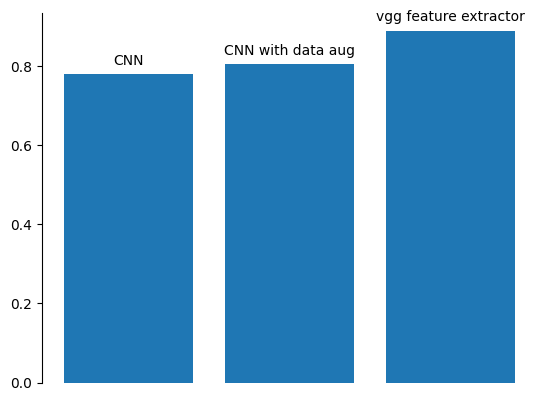

In [66]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1, 2, 3], [cnn_performance, data_aug_performance, vgg_performance], width=0.8)
ax.bar_label(b, labels=['CNN', 'CNN with data aug', 'vgg feature extractor'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)

## Part 4: Visualizing the learned features

In [67]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape

(3, 3, 3, 64)

In [68]:
def kernel_image(weights, i, positive):

    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k

    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m

    return k

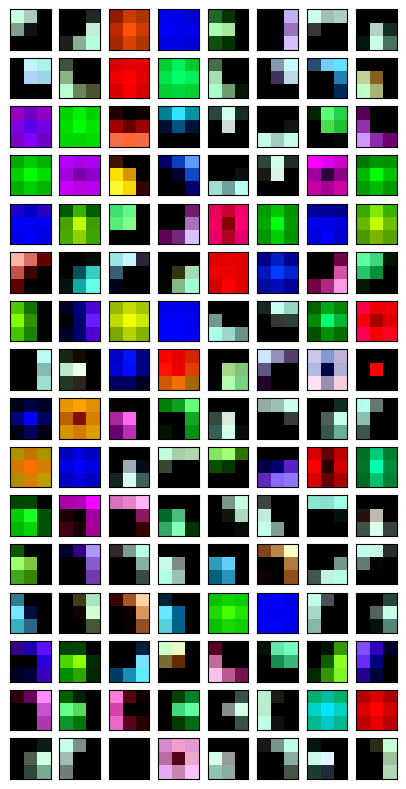

In [84]:
f, ax = plt.subplots(16,8, figsize=(5,10))
ax = ax.reshape(16*8)
for i in range(first_layer_weights.shape[3]):
    ax[2*i].set_xticks([])
    ax[2*i].set_yticks([])
    ax[2*i].grid(False)
    ax[2*i].imshow(kernel_image(first_layer_weights, i, True))
    ax[2*i+1].set_xticks([])
    ax[2*i+1].set_yticks([])
    ax[2*i+1].grid(False)
    ax[2*i+1].imshow(kernel_image(first_layer_weights, i, False))
plt.show()


In the above plot, two consecutive subfigures plot the positive and negative part of our kernels.

While positive and negative parts often being the inverse of each other both in color and in shape, it is hard to get a good understanding of what our CNN is doing at this early stage.